In [481]:
import os
import requests

import math
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import folium
from osgeo import gdal
from rasterio.plot import show_hist
from xml.dom import minidom
import planet
import matplotlib.colors as colors

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

## Functions

In [482]:
# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def scale(band):
    return band/10000.0

## Sindo planet scope data

In [498]:
main_path = "/Users/aida/Documents/Modules/Thesis/lake-victoria/data/planet/sawa-data/"
regions = ["mfangano", "sindo", "mulukoba", "nyanchebe", "siungu", "usenge-anyanga-uwaria", "utonga"]

location = "Fujian-1/"
product_type = "PSScene/files/"
file_name = "composite.tif"
print(main_path + location + product_type + file_name)
img = rasterio.open(main_path + location + product_type + file_name)


/Users/aida/Documents/Modules/Thesis/lake-victoria/data/planet/sawa-data/Fujian-1/PSScene/files/composite.tif


In [499]:
xres = (img.bounds.right - img.bounds.left) / img.width
yres = (img.bounds.top - img.bounds.bottom) / img.height

print(xres, yres)
print("Are the pixels square: {}".format(xres == yres))

3.0 3.0
Are the pixels square: True


In [500]:
print(img.crs)

# Convert pixel coordinates to world coordinates.

# Upper left pixel
row_min = 0
col_min = 0

# Lower right pixel.  Rows and columns are zero indexing.
row_max = img.height - 1
col_max = img.width - 1

# Transform coordinates with the dataset's affine transformation.
topleft = img.transform * (row_min, col_min)
botright = img.transform * (row_max, col_max)

print("Top left corner coordinates: {}".format(topleft))
print("Bottom right corner coordinates: {}".format(botright))

EPSG:32650
Top left corner coordinates: (725343.0, 2805801.0)
Bottom right corner coordinates: (728553.0, 2801520.0)


In [501]:
# All of the metadata required to create an image of the same dimensions, datatype, format, etc. is stored in
# one location.
print(img.meta)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 1428, 'height': 1071, 'count': 8, 'crs': CRS.from_epsg(32650), 'transform': Affine(3.0, 0.0, 725343.0,
       0.0, -3.0, 2805801.0)}


In [503]:
# sequence of band indexes
print(img.indexes)
# Load the 4 bands into 2d arrays - recall that we previously learned PlanetScope band order is BGRN.
# PlanetScope 4-band band order: BGRN
#b, g, r, n = img.read()

# PlanetScope 8-band band order
cb, b, g1, g, y, r, re, n = img.read(masked=True)


(1, 2, 3, 4, 5, 6, 7, 8)


## normalised RGB bands

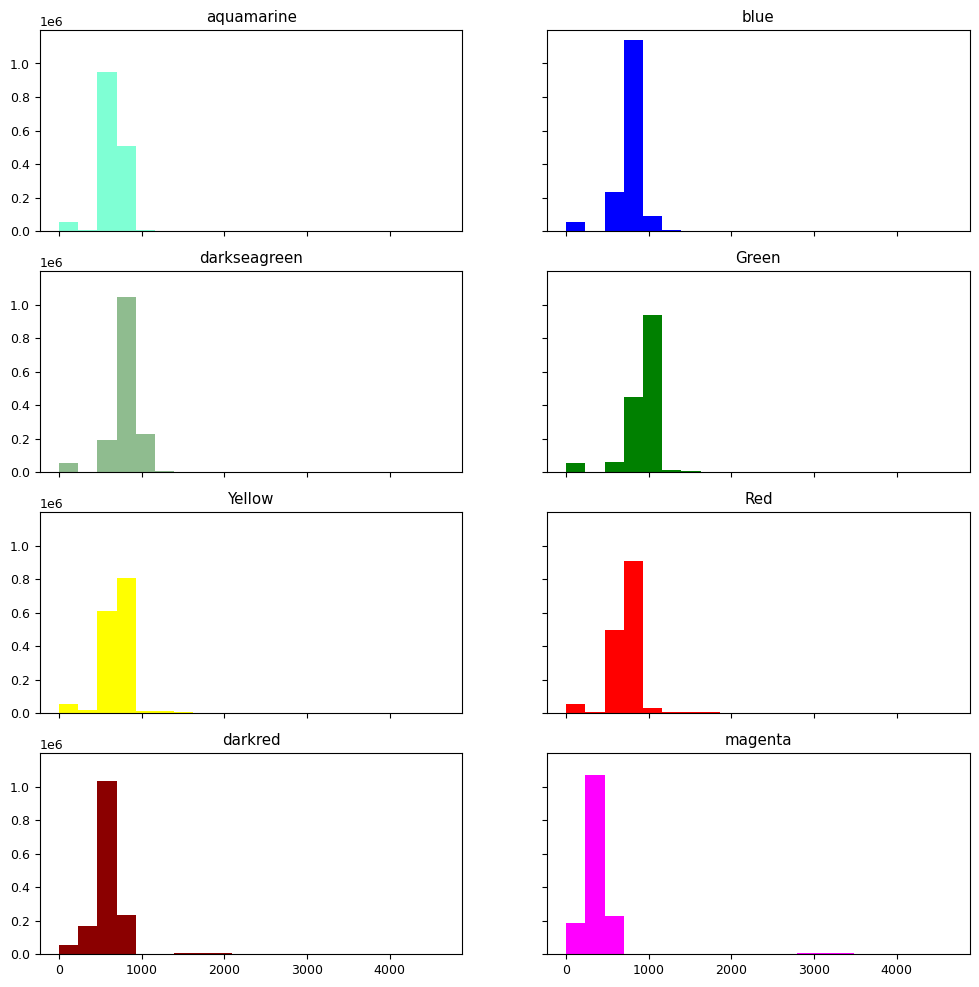

In [505]:
# Create the list of color names for each band
colors_list = [
    "aquamarine",
    "blue",
    "darkseagreen",
    "Green",
    "Yellow",
    "Red",
    "darkred",
    "magenta"
]


# Create the list of titles for each band. The titles and colors listed
# in this example reflect the order and wavelengths of the Landsat 8 bands
titles = ["aquamarine","blue","darkseagreen","Green","Yellow","Red","darkred","magenta"]
#titles = ["blue","Green","Red","magenta"]

bands = np.array([cb, b, g1, g, y, r, re, n])
#bands = np.array([b, g, r, n])

# # Plot the histograms with the color and title lists you just created
# # sphinx_gallery_thumbnail_number = 1
ep.hist(bands, colors=colors_list, title=titles)
plt.show()

In [489]:
# # Normalize the bands
rn = normalize(r)
gn = normalize(g)
bn = normalize(b)
nn = normalize(n)
bands = np.array([bn,gn,rn,nn])

# ep.hist(bands, colors=colors_list, title=titles)
# plt.show()


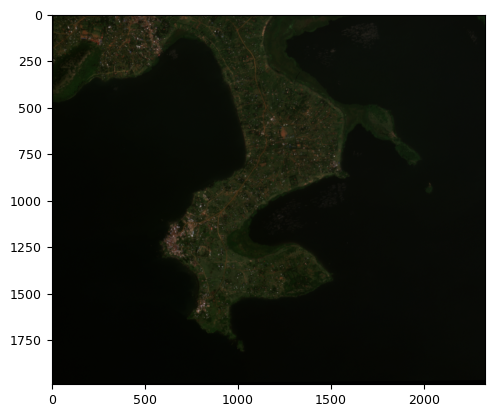

In [490]:
# Create RGB natural color composite
rgb = np.dstack((rn, gn, bn))
# Let's see how our color composite looks like
fig = plt.imshow(rgb)

In [506]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

ndwi = (gn.astype(float) - nn.astype(float)) / (gn + nn)

ndwi_ep = es.normalized_diff(gn, nn)

# check range NDWI values, excluding NaN
np.min(ndwi_ep), np.nanmax(ndwi_ep)

(-0.8720155110646619, 0.9888534787978018)

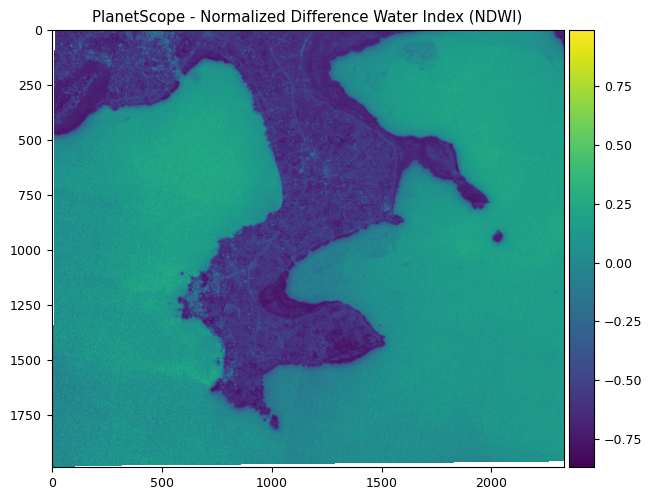

In [492]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
titles = "PlanetScope - Normalized Difference Water Index (NDWI)"
# Plot your data
fig, ax = plt.subplots(figsize=(7, 7))

p = plt.imshow(ndwi_ep, cmap="viridis")
# # Add title and colorbar to show the index
plt.title(titles)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(p, cax=cax)
#save the image
plt.imsave(main_path + location + product_type + "composit-ndwi.png", ndwi_ep)


In [493]:
# Create classes and apply to NDWI results
ndwi_class_bins = [-1, -0.03 , 0.9]
ndwi_planet_class = np.digitize(ndwi, ndwi_class_bins)

# Apply the nodata mask to the newly classified NDWI data
ndwi_planet_class = np.ma.masked_where(
    np.ma.getmask(ndwi), ndwi_planet_class
)
np.unique(ndwi_planet_class)


masked_array(data=[1, 2, 3],
             mask=False,
       fill_value=999999)

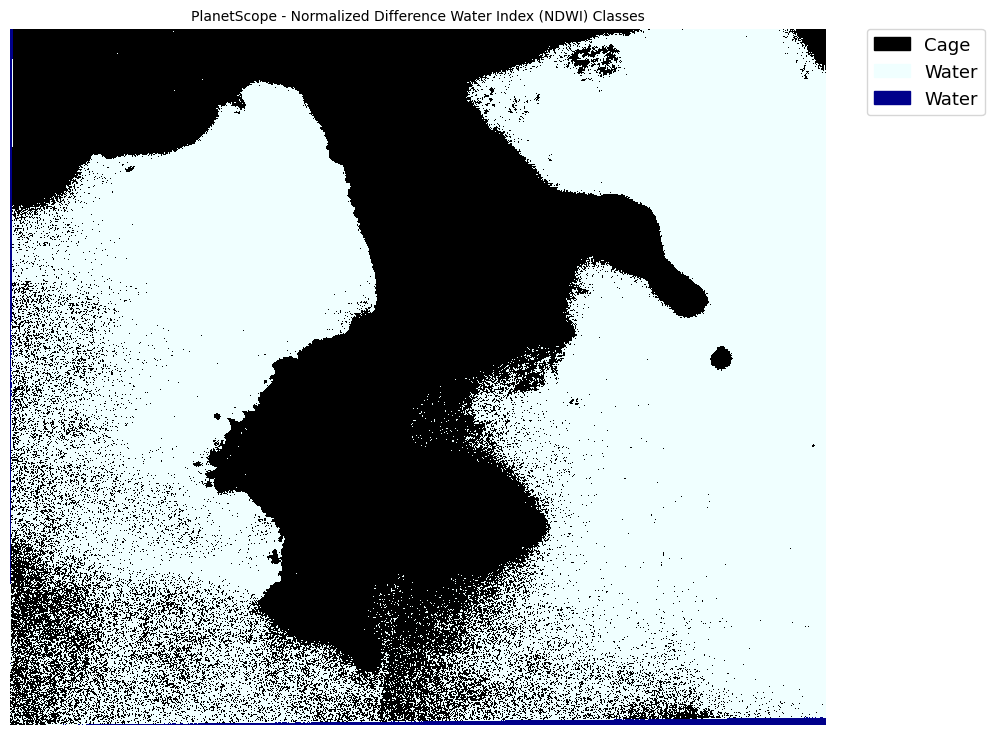

In [494]:
from matplotlib.colors import ListedColormap
# Define color map
nbr_colors = ["black", "azure", "darkblue"]
nbr_cmap = ListedColormap(nbr_colors)

# Define class names
ndwi_cat_names = [
    "Cage",
    "Water",
    "Water"
]

# Get list of classes
classes = np.unique(ndwi_planet_class)
classes = classes.tolist()
# The mask returns a value of none in the classes. remove that
classes = classes[0:3]

# Plot your data
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(ndwi_planet_class, cmap=nbr_cmap)

ep.draw_legend(im_ax=im, classes=classes, titles=ndwi_cat_names)
ax.set_title(
    "PlanetScope - Normalized Difference Water Index (NDWI) Classes",
    fontsize=10,
)
ax.set_axis_off()
plt.tight_layout()
plt.savefig(main_path + location + "/" + product_type  + "ndwi-classes.png")    


In [495]:
# from skimage import io, color
# from skimage import data
# from skimage.filters import threshold_mean

# image = io.imread(main_path + location + product_type + "composit-ndwi.png", as_gray=True) # NDWI image is used further


# thresh = 0.38
# binary = image > thresh

# fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# ax[0, 0].imshow(image, cmap=plt.cm.gray)
# ax[0, 0].set_title('Original')

# ax[0, 1].hist(image.ravel(), bins=256)
# ax[0, 1].set_title('Histogram')

# ax[1, 0].imshow(binary, cmap=plt.cm.gray)
# ax[1, 0].set_title('Thresholded (min)')

# ax[1, 1].hist(image.ravel(), bins=256)
# ax[1, 1].axvline(thresh, color='r')

# for a in ax[:, 0]:
#     a.axis('off')
# plt.show()

# plt.savefig(main_path + location + product_type + "ndwi_threshold.png")


## Otsu thresholding

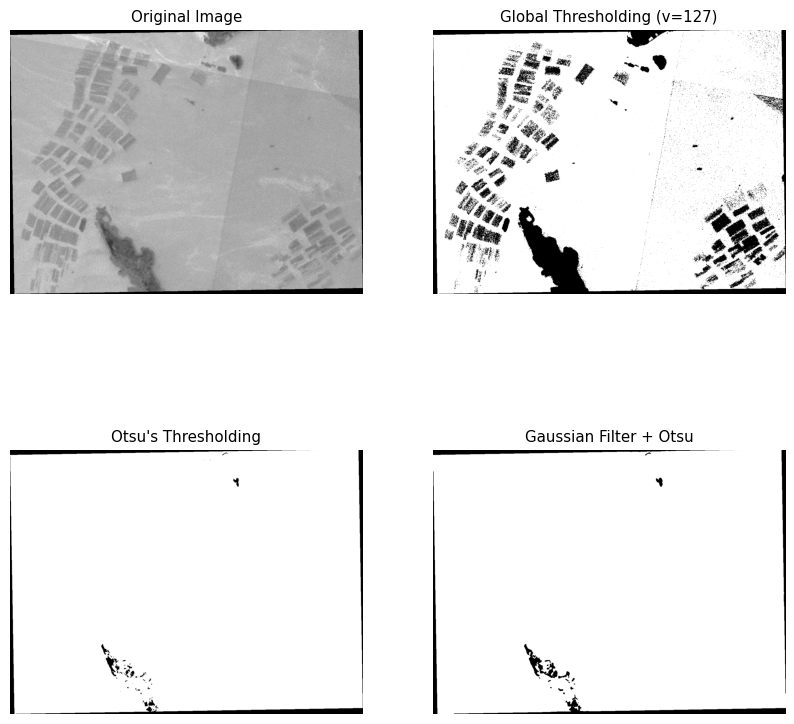

In [507]:
import cv2

from matplotlib import pyplot as plt
img = cv2.imread(main_path + location + product_type + "composit-ndwi.png",0)

# Apply global (simple) thresholding on image
ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

# Apply Otsu's thresholding on image
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Apply Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(7,7),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

titles = ['Original Image','Global Thresholding (v=127)',"Otsu's Thresholding",'Gaussian Filter + Otsu']
images = [img,th1,th2,th3]
plt.figure(figsize = (10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.axis("off")

plt.savefig(main_path + location + product_type + "otsu_threshold.png")    
plt.show()

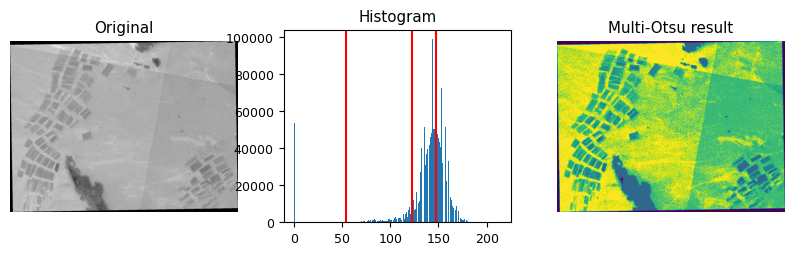

In [510]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.filters import threshold_multiotsu

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# The input image.
image = cv2.imread(main_path + location + product_type + "composit-ndwi.png",0)

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image, classes=4)

# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 2.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='viridis')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')
plt.subplots_adjust()
plt.savefig(main_path + location + product_type + "multi_otsu_threshold.png")    
plt.show()